# Chương II

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scattertext as st
import plotly.graph_objects as go
from plotly.offline import plot
from imageio import imread, imwrite
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display, HTML
import os, json, urllib
from urllib.request import urlopen
from scattertext import CorpusFromPandas, produce_scattertext_explorer
from sklearn.svm import LinearSVC

import gc
import re
import string
import operator
from collections import defaultdict

# Cài đặt tùy chọn hiển thị
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500) 
pd.set_option('display.width', 1000)

# Sử dụng Tokenizer từ TensorFlow
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn import model_selection, naive_bayes, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
display(HTML("<style>.container { width:98% !important; }</style>"))

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

# Đặt hạt giống để đảm bảo tính tái lập
SEED = 1337


c:\Users\qn570\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Đọc data bằng lệnh

In [5]:
disaster_tweets_train = pd.read_csv("D:/Nhom15DHIOT17A/Codes/data/train.csv",  dtype={'id': np.int16, 'target': np.int8})
disaster_tweets_test = pd.read_csv("D:/Nhom15DHIOT17A/Codes/data/test.csv",dtype={'id': np.int16})

## Data gồm

In [15]:
disaster_tweets_train.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [14]:
disaster_tweets_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int16 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int8  
dtypes: int16(1), int8(1), object(3)
memory usage: 200.9+ KB


### Lọc dữ liệu

In [ ]:
disaster_tweets_train.isna().sum()


id             0
keyword       26
location    1105
text           0
dtype: int64

In [15]:
missing_cols = ['keyword', 'location']
for df in [disaster_tweets_train, disaster_tweets_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

In [16]:
# word_count
disaster_tweets_train['word_count'] = disaster_tweets_train['text'].apply(lambda x: len(str(x).split()))
disaster_tweets_test['word_count'] = disaster_tweets_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
disaster_tweets_train['unique_word_count'] = disaster_tweets_train['text'].apply(lambda x: len(set(str(x).split())))
disaster_tweets_test['unique_word_count'] = disaster_tweets_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
disaster_tweets_train['stop_word_count'] = disaster_tweets_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
disaster_tweets_test['stop_word_count'] = disaster_tweets_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
disaster_tweets_train['url_count'] = disaster_tweets_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
disaster_tweets_test['url_count'] = disaster_tweets_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
disaster_tweets_train['mean_word_length'] = disaster_tweets_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
disaster_tweets_test['mean_word_length'] = disaster_tweets_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
disaster_tweets_train['char_count'] = disaster_tweets_train['text'].apply(lambda x: len(str(x)))
disaster_tweets_test['char_count'] = disaster_tweets_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
disaster_tweets_train['punctuation_count'] = disaster_tweets_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
disaster_tweets_test['punctuation_count'] = disaster_tweets_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
disaster_tweets_train['hashtag_count'] = disaster_tweets_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
disaster_tweets_test['hashtag_count'] = disaster_tweets_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
disaster_tweets_train['mention_count'] = disaster_tweets_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
disaster_tweets_test['mention_count'] = disaster_tweets_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

Samples: {0: 4342, 1: 3271}


C:\Users\qn570\AppData\Local\Temp\ipykernel_17468\2232625662.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




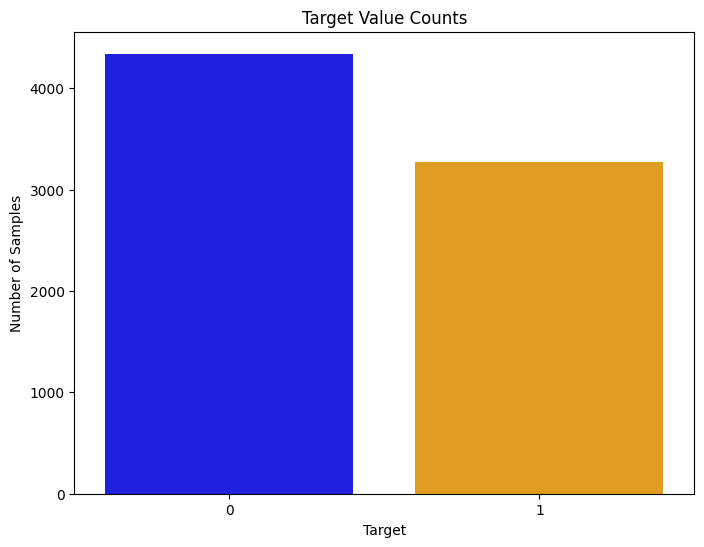

In [17]:
x = disaster_tweets_train.target.value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=x.index, y=x, palette=['blue', 'orange'])
plt.xlabel('Target')
plt.ylabel('Number of Samples')
plt.title('Target Value Counts')
print(f"Samples: {x.to_dict()}")
plt.show()

## Plots for understanding or analysis
### Sử dụng thư viện Matplotlib và Seaborn để tạo ra một biểu đồ cột (countplot) cho dữ liệu "disaster_tweets_train" để  phân tích số lượng tweet về các loại thiên tai khác nhau.



### Trong đó 
##### target = 0 có nghĩa là tweet không phải là tin về thảm họa
##### target = 1 có nghĩa là tweet là tin về thảm họa

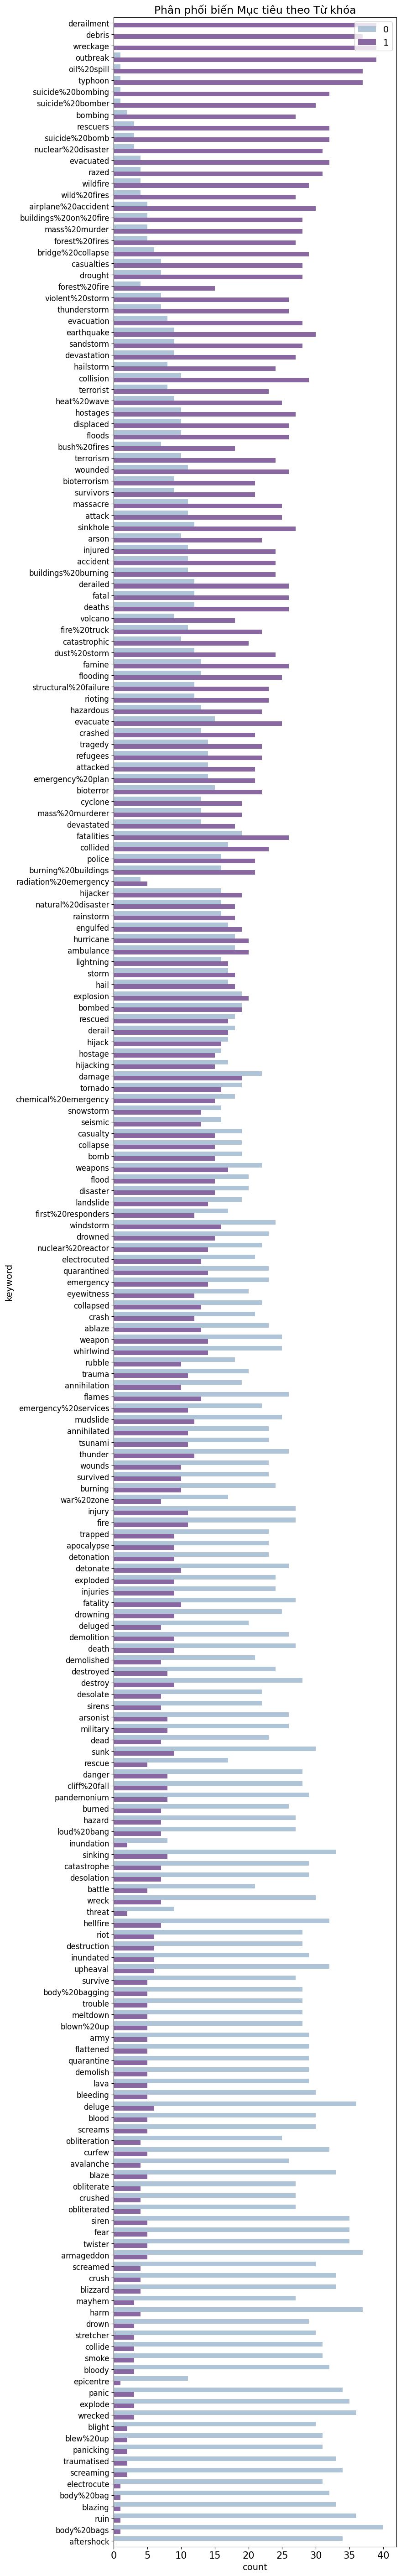

         id keyword location                                               text  target                                       text_cleaned
0         1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...       1  our deeds are the reason of this earthquake ma...
1         4     NaN      NaN             Forest fire near La Ronge Sask. Canada       1              forest fire near la ronge sask canada
2         5     NaN      NaN  All residents asked to 'shelter in place' are ...       1  all residents asked to shelter in place are be...
3         6     NaN      NaN  13,000 people receive #wildfires evacuation or...       1  13000 people receive wildfires evacuation orde...
4         7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...       1  just got sent this photo from ruby alaska as s...
...     ...     ...      ...                                                ...     ...                                                ...
7608  10869     NaN      Na

In [60]:
# Tính toán trung bình của biến 'target' cho mỗi 'keyword'
disaster_tweets_train['target_mean'] = disaster_tweets_train.groupby('keyword')['target'].transform('mean')

# Tạo hình vẽ mới với kích thước 8x72 inch và độ phân giải 100 dpi
fig = plt.figure(figsize=(8, 72), dpi=100)

# Vẽ biểu đồ cột hiển thị phân phối của 'target' theo 'keyword'
# Sắp xếp 'keyword' theo giá trị 'target_mean' giảm dần
# Sử dụng màu 'BuPu' cho palette
sns.countplot(y=disaster_tweets_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=disaster_tweets_train.sort_values(by='target_mean', ascending=False)['target'], palette="BuPu")

# Điều chỉnh kích thước nhãn trên các trục
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)

# Thêm chú thích và tiêu đề
plt.legend(loc=1)
plt.title('Phân phối biến Mục tiêu theo Từ khóa')

# Hiển thị biểu đồ
plt.show()

# Xóa cột 'target_mean' khỏi bảng dữ liệu
disaster_tweets_train.drop(columns=['target_mean'], inplace=True)
# Xuất dữ liệu thành file CSV
disaster_tweets_train.to_csv('disaster_tweets_train.csv', index=False)

# In ra bảng dữ liệu
print(disaster_tweets_train)

## Trong đó 

### Top các keyword chiếm tỉ lệ cao 

C:\Users\qn570\AppData\Local\Temp\ipykernel_17468\3852122891.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




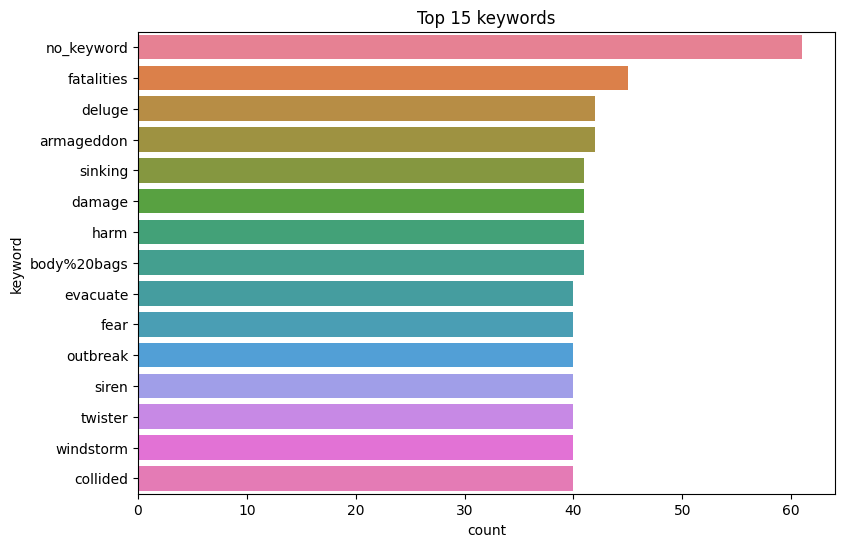

In [19]:
plt.figure(figsize=(9, 6))

# Vẽ biểu đồ cột với màu sắc khác nhau cho từng cột
sns.countplot(y=disaster_tweets_train.keyword,
              order=disaster_tweets_train.keyword.value_counts().iloc[:15].index,
              palette='husl')  # Sử dụng palette 'husl' để có màu sắc khác nhau

plt.title('Top 15 keywords')
plt.show()

### Top 10 các keyword liên quan đến thảm họa 

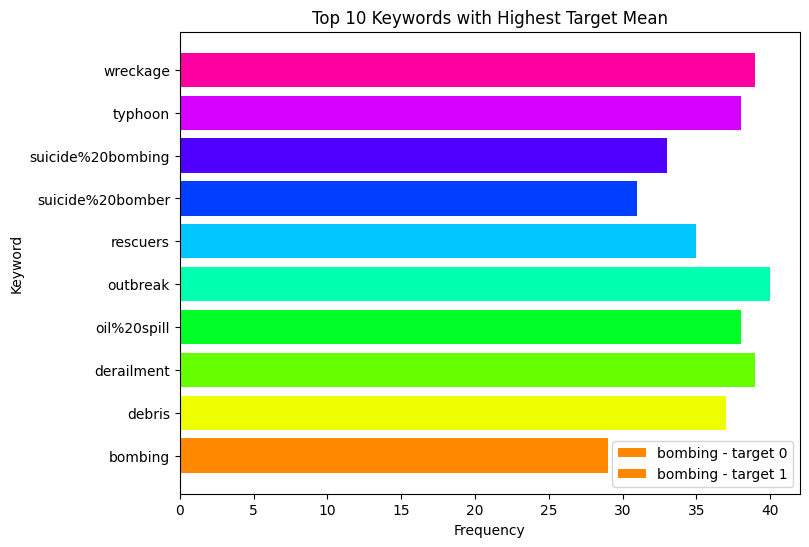

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Tính toán trung bình của biến 'target' cho mỗi 'keyword'
disaster_tweets_train['target_mean'] = disaster_tweets_train.groupby('keyword')['target'].transform('mean')

# Lấy top 10 từ khóa có giá trị trung bình của 'target' cao nhất
top_10_keywords = disaster_tweets_train.groupby('keyword')['target'].mean().nlargest(10).index

# Lọc bảng dữ liệu chỉ chứa các từ khóa trong top 10
top_10_data = disaster_tweets_train[disaster_tweets_train['keyword'].isin(top_10_keywords)]

# Sắp xếp dữ liệu theo 'target_mean'
top_10_data = top_10_data.sort_values(by='target_mean', ascending=False)

# Tạo bảng đếm cho từ khóa và target
count_data = top_10_data.groupby(['keyword', 'target']).size().unstack(fill_value=0)

# Tạo một danh sách màu sắc khác nhau cho mỗi từ khóa
unique_colors = sns.color_palette("hsv", len(count_data))

# Tạo hình vẽ mới với kích thước 8x6 inch và độ phân giải 100 dpi
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

# Vẽ biểu đồ thanh với mỗi cột một màu riêng biệt
for i, (keyword, counts) in enumerate(count_data.iterrows()):
    # Vẽ các thanh màu khác nhau cho mỗi từ khóa
    ax.barh(keyword, counts[0], color=unique_colors[i], label=f'{keyword} - target 0' if i == 0 else "")
    ax.barh(keyword, counts[1], color=unique_colors[i], left=counts[0], label=f'{keyword} - target 1' if i == 0 else "")

# Điều chỉnh nhãn và tiêu đề
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.title("Top 10 Keywords with Highest Target Mean")

# Hiển thị chú thích cho một số từ khóa tiêu biểu
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), loc="best")

# Hiển thị biểu đồ
plt.show()

# Xóa cột 'target_mean' khỏi bảng dữ liệu
disaster_tweets_train.drop(columns=['target_mean'], inplace=True)



### 50 từ làm sạch

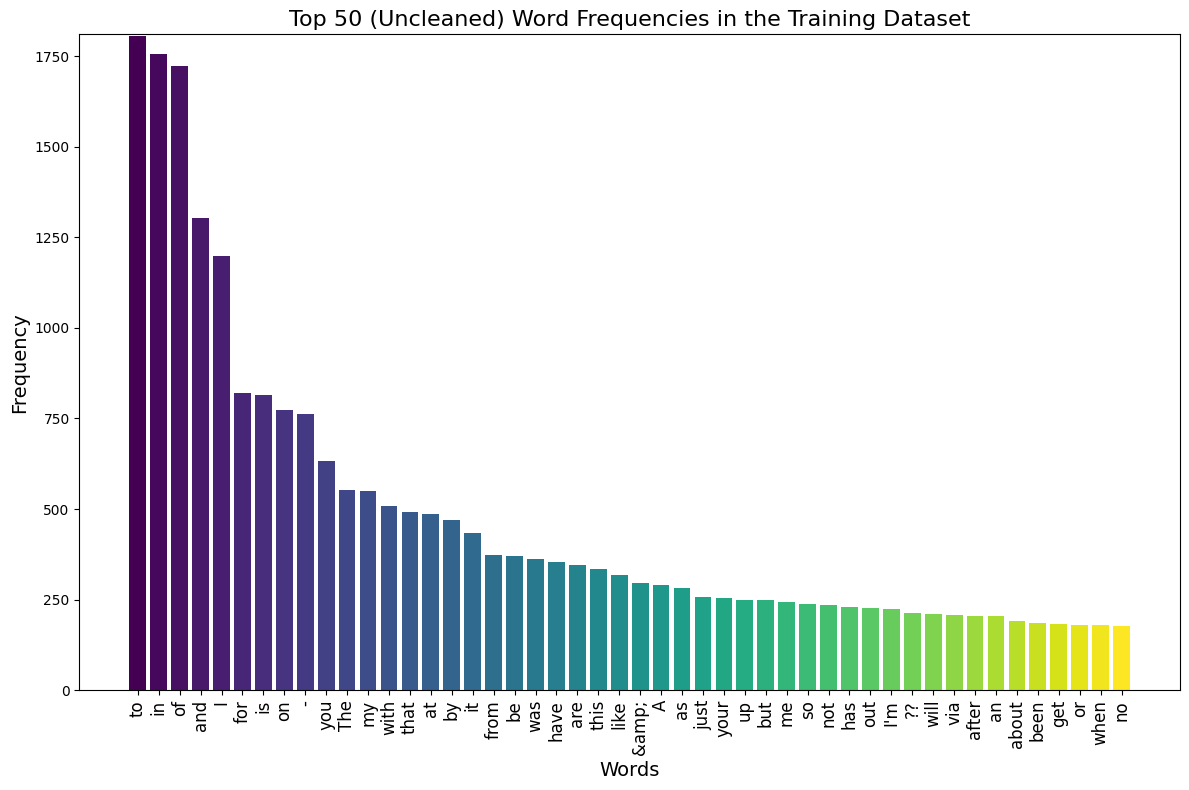

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Đếm tần suất xuất hiện của các từ trong cột 'text'
all_words = disaster_tweets_train['text'].str.split(expand=True).unstack().value_counts()

# Lấy danh sách từ và số lần xuất hiện từ thứ 3 đến thứ 50
words = all_words.index[2:50]
frequencies = all_words.values[2:50]

# Tạo hình vẽ mới với kích thước 12x8 inch
plt.figure(figsize=(12, 8))

# Tạo danh sách màu sắc khác nhau cho mỗi cột
colors = plt.cm.viridis(np.linspace(0, 1, len(words)))  # Sử dụng bảng màu 'viridis' với số lượng màu tương ứng

# Vẽ biểu đồ thanh cho top 50 từ
plt.bar(words, frequencies, color=colors)  # Áp dụng màu sắc đã tạo

# Thiết lập tiêu đề và nhãn trục
plt.title('Top 50 (Uncleaned) Word Frequencies in the Training Dataset', fontsize=16)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Xoay nhãn từ trên trục x để dễ đọc
plt.xticks(rotation=90, fontsize=12)

# Điều chỉnh giới hạn trục y để hiển thị tốt hơn
plt.ylim(0, max(frequencies) + 5)

# Hiển thị biểu đồ
plt.tight_layout()  # Tự động điều chỉnh layout cho phù hợp
plt.show()




# Natural Language Processing

## Các bước thực hiện mà nhóm đề ra 

#### Bước 1: Phân tách từ (Tokenization) : - Đây là bước chuyển câu thành các chuỗi và sau đó tách các chuỗi thành từ. Bước này là cơ bản trong bất kỳ bài toán NLP nào vì hiểu văn bản đòi hỏi khả năng diễn giải từng từ và câu trong đó.

#### Bước 2: Loại bỏ từ dừng (Stopwords) - Các từ xuất hiện thường xuyên nhưng không có ý nghĩa phân biệt (như “là”, “và”) sẽ được loại bỏ vì chúng ít giúp ích trong việc xác định nội dung quan trọng.

#### Bước 3: Rút gọn từ gốc (Stemming) - Quá trình rút các từ có biến thể về dạng gốc để chúng mang ý nghĩa chung nhất, giúp thuật toán nhận diện các dạng khác nhau của cùng một từ.

#### Bước 4: Vector hóa (Vectorization) - Biến văn bản thành vector để dễ phân tích. Phương pháp bag-of-words phổ biến nhất, tạo ra ma trận số lần xuất hiện của từ, giúp mã hóa văn bản thành định dạng dễ hiểu cho mô hình.

In [ ]:
import numpy as np
import pandas as pd
import spacy

# Tải dữ liệu từ file CSV
disaster_tweets_train = pd.read_csv("D:/Nhom15DHIOT17A/Codes/data/train.csv",  dtype={'id': np.int16, 'target': np.int8})

# Hàm làm sạch văn bản
def clean_text(text):
    # Xóa dấu câu và chuyển về chữ thường
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    # Có thể thêm các bước làm sạch khác như xóa stopwords, stemming, v.v.
    return text

# Áp dụng hàm làm sạch
disaster_tweets_train['text_cleaned'] = disaster_tweets_train['text'].apply(clean_text)

# Tải mô hình spaCy
nlp = spacy.load('en_core_web_sm')

# Tạo bản sao của DataFrame và áp dụng mô hình spaCy
disaster_tweets_train_vi = disaster_tweets_train.copy()
disaster_tweets_train_vi['parsed'] = disaster_tweets_train_vi['text_cleaned'].apply(nlp)

# Hiển thị một số kết quả
print(disaster_tweets_train_vi[['text', 'text_cleaned', 'parsed']].head())

# Nếu bạn muốn lấy một số thông tin từ các đối tượng đã phân tích
disaster_tweets_train_vi['n_tokens'] = disaster_tweets_train_vi['parsed'].apply(lambda x: len(x))
print(disaster_tweets_train_vi[['text', 'text_cleaned', 'n_tokens']].head())


                                                text                                       text_cleaned                                             parsed
0  Our Deeds are the Reason of this #earthquake M...  our deeds are the reason of this earthquake ma...  (our, deeds, are, the, reason, of, this, earth...
1             Forest fire near La Ronge Sask. Canada              forest fire near la ronge sask canada      (forest, fire, near, la, ronge, sask, canada)
2  All residents asked to 'shelter in place' are ...  all residents asked to shelter in place are be...  (all, residents, asked, to, shelter, in, place...
3  13,000 people receive #wildfires evacuation or...  13000 people receive wildfires evacuation orde...  (13000, people, receive, wildfires, evacuation...
4  Just got sent this photo from Ruby #Alaska as ...  just got sent this photo from ruby alaska as s...  (just, got, sent, this, photo, from, ruby, ala...
                                                text                  

### In ra số lượng tweet và từ

In [23]:
print("Số lượng tweet")
print(disaster_tweets_train_vi.groupby('keyword')['text'].count())
print("Số lượng từ")
disaster_tweets_train.groupby('keyword').apply(lambda x: x.text.apply(lambda x: len(x.split())).sum())

Số lượng tweet
keyword
ablaze                   36
accident                 35
aftershock               34
airplane%20accident      35
ambulance                38
annihilated              34
annihilation             29
apocalypse               32
armageddon               42
army                     34
arson                    32
arsonist                 34
attack                   36
attacked                 35
avalanche                30
battle                   26
bioterror                37
bioterrorism             30
blaze                    38
blazing                  34
bleeding                 35
blew%20up                33
blight                   32
blizzard                 37
blood                    35
bloody                   35
blown%20up               33
body%20bag               33
body%20bagging           33
body%20bags              41
bomb                     34
bombed                   38
bombing                  29
bridge%20collapse        35
buildings%20burning      

C:\Users\qn570\AppData\Local\Temp\ipykernel_17468\1167002761.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



keyword
ablaze                   501
accident                 534
aftershock               507
airplane%20accident      536
ambulance                487
annihilated              534
annihilation             464
apocalypse               485
armageddon               606
army                     500
arson                    408
arsonist                 370
attack                   505
attacked                 557
avalanche                415
battle                   383
bioterror                552
bioterrorism             470
blaze                    486
blazing                  511
bleeding                 458
blew%20up                491
blight                   474
blizzard                 408
blood                    461
bloody                   500
blown%20up               566
body%20bag               582
body%20bagging           493
body%20bags              579
bomb                     449
bombed                   576
bombing                  396
bridge%20collapse        552
buildi

C:\Users\qn570\AppData\Local\Temp\ipykernel_17468\176197669.py:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




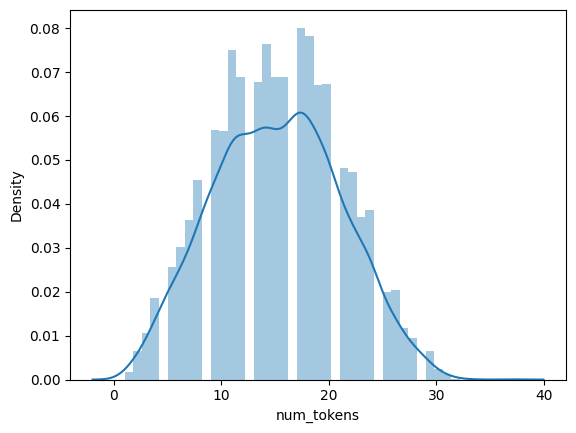

In [24]:
# Sum the number of tokens in each Doc
disaster_tweets_train_vi['num_tokens'] = [len(token) for token in disaster_tweets_train_vi.parsed]
# Visualize histogram of tokens per tweet
g = sns.distplot(disaster_tweets_train_vi.num_tokens)

In [25]:
disaster_tweets_train_vi

,id,keyword,location,text,target,text_cleaned,parsed,n_tokens,num_tokens
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"(our, deeds, are, the, reason, of, this, earth...",13,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"(forest, fire, near, la, ronge, sask, canada)",7,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"(all, residents, asked, to, shelter, in, place...",22,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"(13000, people, receive, wildfires, evacuation...",8,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"(just, got, sent, this, photo, from, ruby, ala...",16,16
...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...,"(two, giant, cranes, holding, a, bridge, colla...",11,11
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrary thetawniest the out of control wild...,"(ariaahrary, thetawniest, the, out, of, contro...",20,20
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m194 0104 utc5km s of volcano hawaii httptcozd...,"(m194, 0104, utc5, km, s, of, volcano, hawaii,...",9,9
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating after an ebike collided w...,"(police, investigating, after, an, ebike, coll...",19,19


## Logistic regression

In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('D:/Nhom15DHIOT17A/Codes/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

D:/Nhom15DHIOT17A/Codes/data\sample_submission.csv
D:/Nhom15DHIOT17A/Codes/data\test.csv
D:/Nhom15DHIOT17A/Codes/data\train.csv


In [27]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

In [28]:
plt.rcParams.update({'font.size': 14})

# Load data
train = pd.read_csv("D:/Nhom15DHIOT17A/Codes/data/train.csv")
test = pd.read_csv("D:/Nhom15DHIOT17A/Codes/data/test.csv")
sub_sample = pd.read_csv("D:/Nhom15DHIOT17A/Codes/data/sample_submission.csv")

print (train.shape, test.shape, sub_sample.shape)

(7613, 5) (3263, 4) (3263, 2)


# Understanding Data

In [29]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


C:\Users\qn570\AppData\Local\Temp\ipykernel_17468\3470069618.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




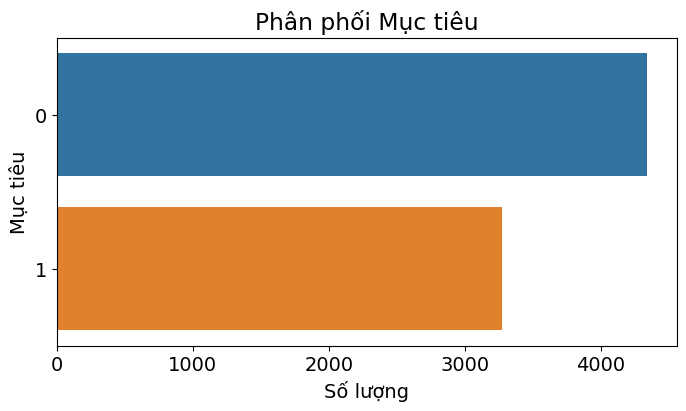

In [61]:
# Đảm bảo bạn đã thực hiện bỏ các bản ghi trùng lặp và reset lại chỉ số
train.duplicated().sum()  # Kiểm tra số lượng bản ghi trùng lặp
train = train.drop_duplicates().reset_index(drop=True)  # Xóa bản ghi trùng lặp và reset lại chỉ số

# Vẽ biểu đồ với hai màu khác nhau cho mỗi giá trị của target
plt.figure(figsize=(8, 4))  # Thiết lập kích thước biểu đồ
sns.countplot(y=train.target, palette=["#1f77b4", "#ff7f0e"])  # Vẽ biểu đồ cột, sử dụng hai màu khác nhau
plt.title('Phân phối Mục tiêu')  # Tiêu đề biểu đồ
plt.xlabel('Số lượng')  # Nhãn trục x
plt.ylabel('Mục tiêu')  # Nhãn trục y
plt.show()  # Hiển thị biểu đồ

In [31]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [32]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [33]:
sub_sample.isnull().sum()

id        0
target    0
dtype: int64

#### Kiểm tra tập dữ liệu train và dữ liệu test có bằng nhau về số lượng không

In [34]:
print (train.keyword.nunique(), test.keyword.nunique())

221 221


In [35]:
#### Most common words

C:\Users\qn570\AppData\Local\Temp\ipykernel_17468\223845290.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




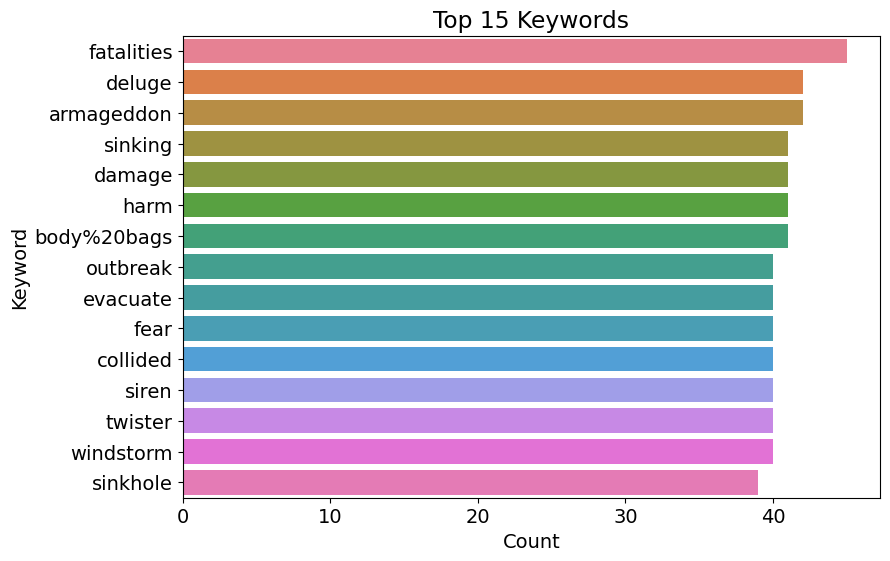

In [36]:
# Tạo bảng màu với số màu bằng số cột
palette = sns.color_palette("husl", 15)  # "husl" là một ví dụ, bạn có thể thử các bảng màu khác

# Vẽ biểu đồ với các cột có màu khác nhau
plt.figure(figsize=(9, 6))
sns.countplot(
    y=train.keyword,
    order=train.keyword.value_counts().iloc[:15].index,
    palette=palette
)
plt.title('Top 15 Keywords')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.show()


#### Top 10 words in disaster and non-disaster tweets

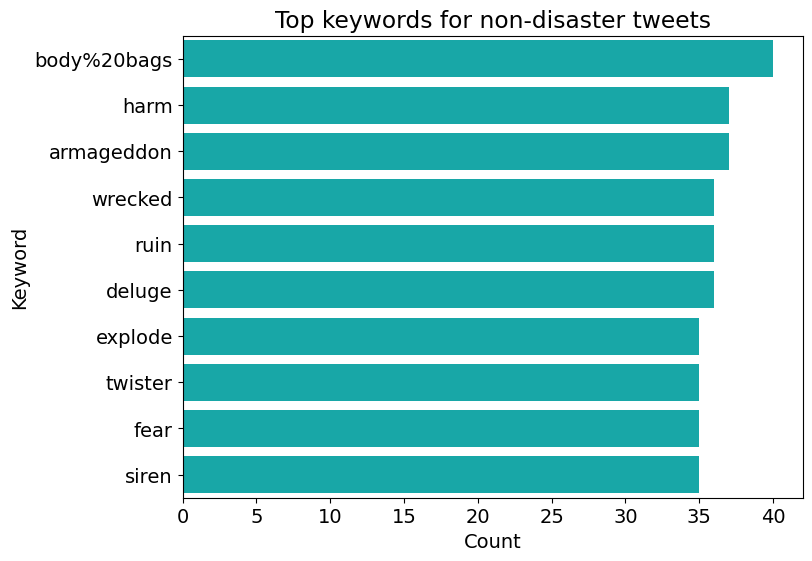

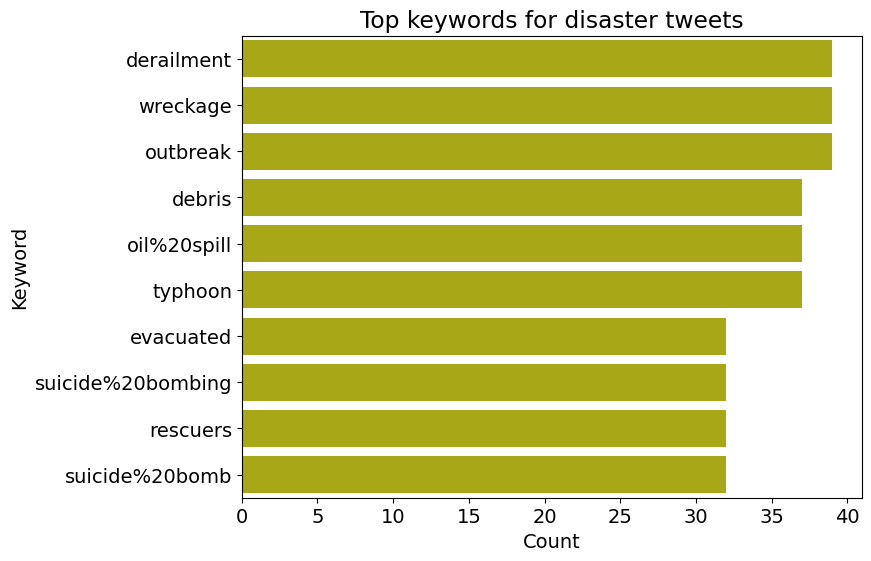

In [37]:
# Lấy top 10 từ khóa cho các tweet không phải là thảm họa
kw_nd = train[train.target == 0].keyword.value_counts().head(10)

# Vẽ biểu đồ thanh cho từ khóa của các tweet thảm họa
plt.figure(figsize=(8, 6))
sns.barplot(x=kw_nd.values, y=kw_nd.index, color='c')
plt.title('Top keywords for non-disaster tweets')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.show()

# Lấy top 10 từ khóa cho các tweet thảm họa
kw_d = train[train.target == 1].keyword.value_counts().head(10)

# Vẽ biểu đồ thanh cho từ khóa của các tweet không phải là thảm họa
plt.figure(figsize=(8, 6))
sns.barplot(x=kw_d.values, y=kw_d.index, color='y')
plt.title('Top keywords for disaster tweets')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.show()


There is no common top 10 keywords between disaster and non-disaster tweets.

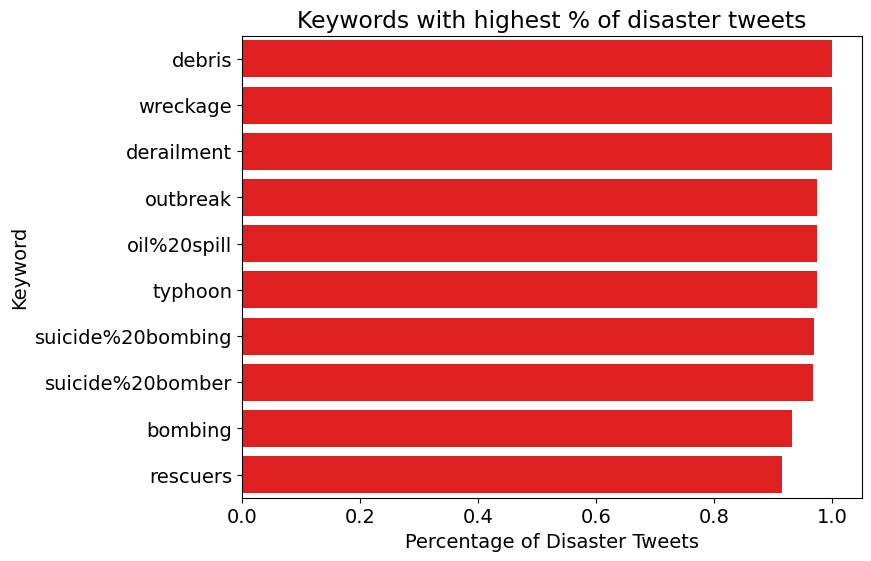

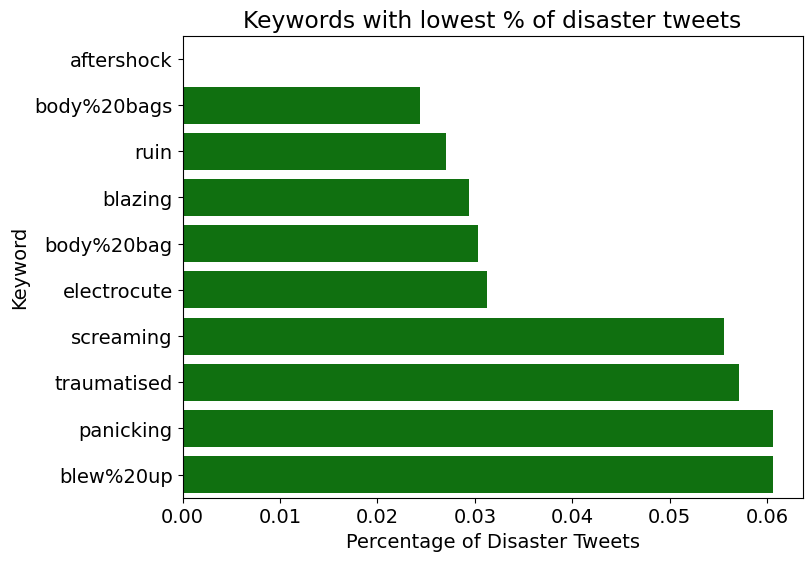

In [38]:
# Chuyển cột 'target' về kiểu số, loại bỏ các giá trị không hợp lệ
train['target'] = pd.to_numeric(train['target'], errors='coerce')

# Lấy top từ khóa với tỷ lệ tweet thảm họa cao nhất
top_d = train.groupby('keyword')['target'].mean().dropna().sort_values(ascending=False).head(10)

# Lấy top từ khóa với tỷ lệ tweet thảm họa thấp nhất
top_nd = train.groupby('keyword')['target'].mean().dropna().sort_values().head(10)

# Vẽ biểu đồ cho từ khóa với tỷ lệ tweet thảm họa cao nhất
plt.figure(figsize=(8, 6))
sns.barplot(x=top_d.values, y=top_d.index, color='red')
plt.title('Keywords with highest % of disaster tweets')
plt.xlabel('Percentage of Disaster Tweets')
plt.ylabel('Keyword')
plt.show()

# Vẽ biểu đồ cho từ khóa với tỷ lệ tweet thảm họa thấp nhất
plt.figure(figsize=(8, 6))
sns.barplot(x=top_nd.values, y=top_nd.index, color='green')
plt.title('Keywords with lowest % of disaster tweets')
plt.xlabel('Percentage of Disaster Tweets')
plt.ylabel('Keyword')
plt.show()


In [39]:
# Check number of unique keywords and locations
print (train.location.nunique(), test.location.nunique())

3341 1602


C:\Users\qn570\AppData\Local\Temp\ipykernel_17468\2354454520.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




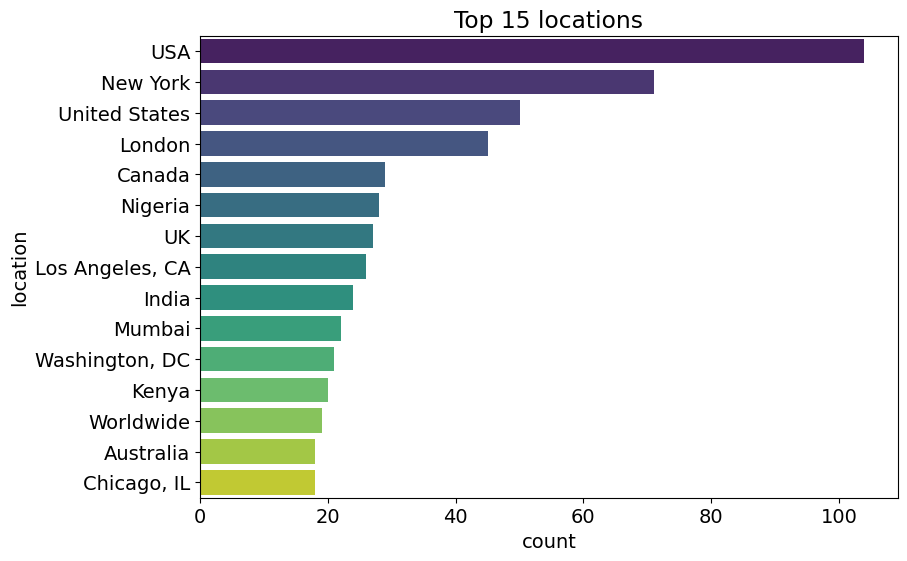

In [40]:
# Most common locations
plt.figure(figsize=(9,6))
sns.countplot(
    y=train.location, 
    order=train.location.value_counts().iloc[:15].index,
    palette='viridis'  # Dùng bảng màu 'viridis' để mỗi cột có màu khác nhau
)
plt.title('Top 15 locations')
plt.show()

As location is free text, the data is not clean, you can see both 'USA' and 'United States' in top locations. We than have a look at % of disaster tweets for common locations.

C:\Users\qn570\AppData\Local\Temp\ipykernel_17468\876779291.py:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




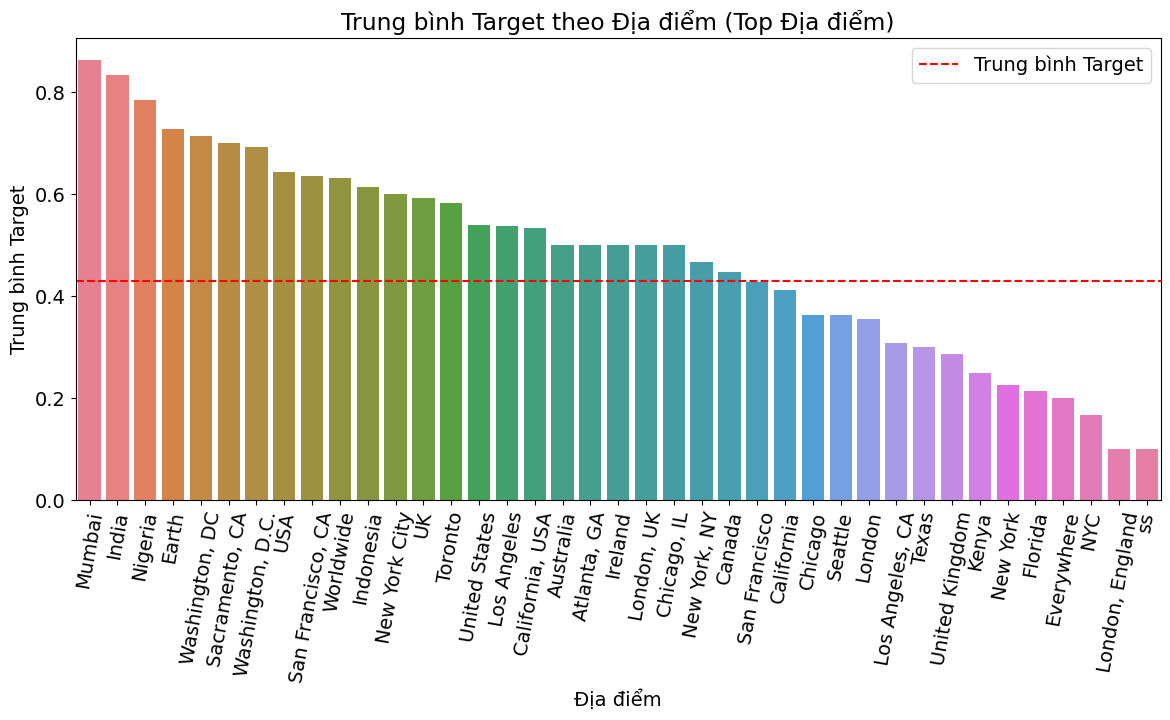

In [62]:
# Chuyển đổi cột 'target' về kiểu số
train['target'] = pd.to_numeric(train['target'], errors='coerce')

# Xóa các hàng có giá trị NaN trong cột 'target'
train = train.dropna(subset=['target'])

# Tính toán tần suất các địa điểm
raw_loc = train.location.value_counts()
top_loc = list(raw_loc[raw_loc >= 10].index)

# Lọc các hàng có địa điểm nằm trong top_loc
top_only = train[train.location.isin(top_loc)]

# Tính trung bình của target theo location
top_l = top_only.groupby('location')['target'].agg('mean').sort_values(ascending=False)

# Vẽ biểu đồ với mỗi cột một màu
plt.figure(figsize=(14, 6))

# Tạo danh sách màu sắc, có thể thay đổi theo sở thích
colors = sns.color_palette("husl", len(top_l))  # Sử dụng bảng màu Husl để lấy nhiều màu sắc

# Vẽ biểu đồ với danh sách màu sắc
sns.barplot(x=top_l.index, y=top_l, palette=colors)

plt.axhline(np.mean(train.target), color='red', linestyle='--', label='Trung bình Target')
plt.xticks(rotation=80)
plt.title('Trung bình Target theo Địa điểm (Top Địa điểm)')
plt.xlabel('Địa điểm')
plt.ylabel('Trung bình Target')
plt.legend()
plt.show()

# Cleaning the data

In [42]:
import re
test_str = train.loc[417, 'text']
def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text)           # Remove line breaks
    text = re.sub('\s+', ' ', text).strip()  # Remove leading, trailing, and extra spaces
    return text

print("Original text: " + test_str)
print("Cleaned text: " + clean_text(test_str))

Original text: Arson suspect linked to 30 fires caught in Northern California http://t.co/mmGsyAHDzb
Cleaned text: Arson suspect linked to 30 fires caught in Northern California


<>:6: SyntaxWarning:

invalid escape sequence '\s'

<>:6: SyntaxWarning:

invalid escape sequence '\s'

C:\Users\qn570\AppData\Local\Temp\ipykernel_17468\3582949484.py:6: SyntaxWarning:

invalid escape sequence '\s'



In [43]:
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))
    # df['hashtags'].fillna(value='no', inplace=True)
    # df['mentions'].fillna(value='no', inplace=True)
    
    return df
    
train = process_text(train)
test = process_text(test)

In [44]:
from wordcloud import STOPWORDS

def create_stat(df):
    # Tweet length
    df['text_len'] = df['text_clean'].apply(len)
    # Word count
    df['word_count'] = df["text_clean"].apply(lambda x: len(str(x).split()))
    # Stopword count
    df['stop_word_count'] = df['text_clean'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    # Punctuation count
    df['punctuation_count'] = df['text_clean'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    # Count of hashtags (#)
    df['hashtag_count'] = df['hashtags'].apply(lambda x: len(str(x).split()))
    # Count of mentions (@)
    df['mention_count'] = df['mentions'].apply(lambda x: len(str(x).split()))
    # Count of links
    df['link_count'] = df['links'].apply(lambda x: len(str(x).split()))
    # Count of uppercase letters
    df['caps_count'] = df['text_clean'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    # Ratio of uppercase letters
    df['caps_ratio'] = df['caps_count'] / df['text_len']
    return df

train = create_stat(train)
test = create_stat(test)

print(train.shape, test.shape)

(7613, 18) (3263, 17)


<>:14: SyntaxWarning:

invalid escape sequence '\s'

<>:14: SyntaxWarning:

invalid escape sequence '\s'

C:\Users\qn570\AppData\Local\Temp\ipykernel_17468\972876008.py:14: SyntaxWarning:

invalid escape sequence '\s'

C:\Users\qn570\AppData\Local\Temp\ipykernel_17468\972876008.py:79: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




stop_word_count     -0.111250
mention_count       -0.049654
caps_ratio          -0.014970
punctuation_count   -0.012535
word_count           0.017081
link_count           0.020244
caps_count           0.027808
hashtag_count        0.032853
id                   0.060781
text_len             0.096435
Name: target, dtype: float64


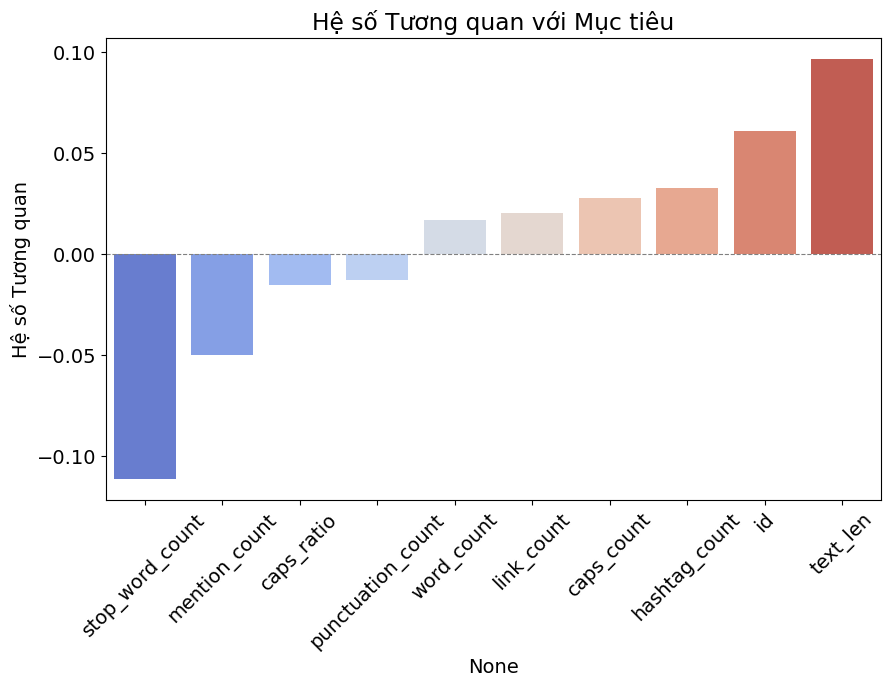

In [63]:
import pandas as pd
import numpy as np
import re
import string
from wordcloud import STOPWORDS

# Giả định rằng DataFrame train đã được tạo và chứa dữ liệu
# Nếu chưa có, bạn cần tải dữ liệu vào DataFrame này trước

# Hàm làm sạch văn bản
def clean_text(text):
    text = re.sub(r'https?://\S+', '', text)  # Xóa link
    text = re.sub(r'\n', ' ', text)            # Xóa dấu ngắt dòng
    text = re.sub('\s+', ' ', text).strip()    # Xóa khoảng trắng dư
    return text

# Hàm tìm hashtag
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

# Hàm tìm mention
def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

# Hàm tìm link
def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

# Hàm xử lý văn bản
def process_text(df):
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))
    return df

# Hàm tạo thống kê
def create_stat(df):
    df['text_len'] = df['text_clean'].apply(len)
    df['word_count'] = df["text_clean"].apply(lambda x: len(str(x).split()))
    df['stop_word_count'] = df['text_clean'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    df['punctuation_count'] = df['text_clean'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    df['hashtag_count'] = df['hashtags'].apply(lambda x: len(str(x).split()))
    df['mention_count'] = df['mentions'].apply(lambda x: len(str(x).split()))
    df['link_count'] = df['links'].apply(lambda x: len(str(x).split()))
    df['caps_count'] = df['text_clean'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    df['caps_ratio'] = df['caps_count'] / df['text_len']
    return df

# Giả định rằng bạn đã tải dữ liệu vào train và test
# train = pd.read_csv('path_to_your_train_data.csv')
# test = pd.read_csv('path_to_your_test_data.csv')

# Xử lý dữ liệu
train = process_text(train)
test = process_text(test)

train = create_stat(train)
test = create_stat(test)


# Đảm bảo biến mục tiêu là kiểu số
train['target'] = pd.to_numeric(train['target'], errors='coerce')

# Chỉ giữ lại các cột số
numeric_train = train.select_dtypes(include=['number'])

# Tính toán độ tương quan và sắp xếp
correlation_with_target = numeric_train.corr()['target'].drop('target').sort_values()

# In ra kết quả
print(correlation_with_target)

# Vẽ biểu đồ độ tương quan
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette='coolwarm')
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.title('Hệ số Tương quan với Mục tiêu')
plt.xticks(rotation=45)
plt.ylabel('Hệ số Tương quan')
plt.show()

From above, we came to know all the statistics have very low co-relation

In [46]:
from nltk import FreqDist, word_tokenize

In [47]:
# Make a set of stop words
stopwords = set(STOPWORDS)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\qn570\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\qn570\AppData\Local\Temp\ipykernel_17468\3083380003.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




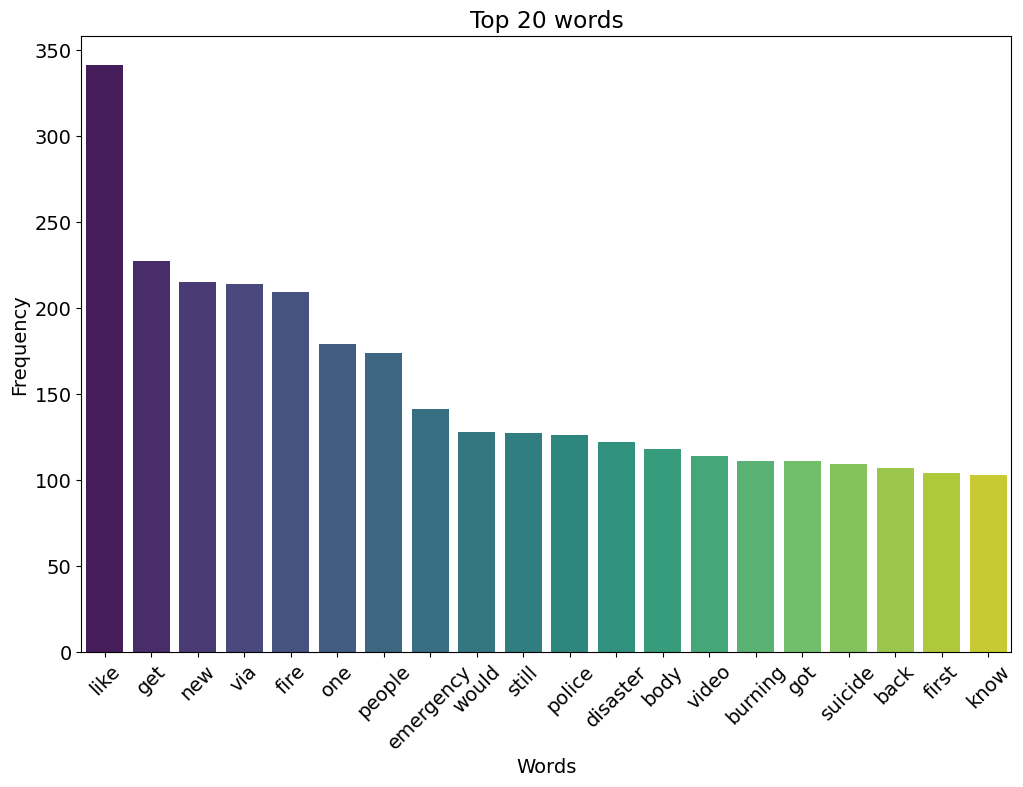

In [54]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk

# Tải bộ từ dừng nếu chưa tải
nltk.download('stopwords')

# Giả sử DataFrame 'train' đã được định nghĩa trước đó
# Ví dụ: train = pd.DataFrame({'text_clean': ["your text data here"]})

# Loại bỏ các giá trị NaN trong 'text_clean'
train['text_clean'] = train['text_clean'].dropna()

# Tính toán tần suất từ
all_words = ' '.join(train['text_clean']).lower().split()
stop_words = set(stopwords.words('english'))
filtered_words = [w for w in all_words if w not in stop_words and w.isalpha()]
word_freq = Counter(filtered_words)

# Chuyển đổi tần suất thành DataFrame
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top20w = df_word_freq.sort_values('count', ascending=False).head(20)

# Vẽ biểu đồ với màu sắc riêng cho từng cột
plt.figure(figsize=(12, 8))
sns.barplot(x=top20w.index, y=top20w['count'], palette=sns.color_palette("viridis", len(top20w)))
plt.title('Top 20 words')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

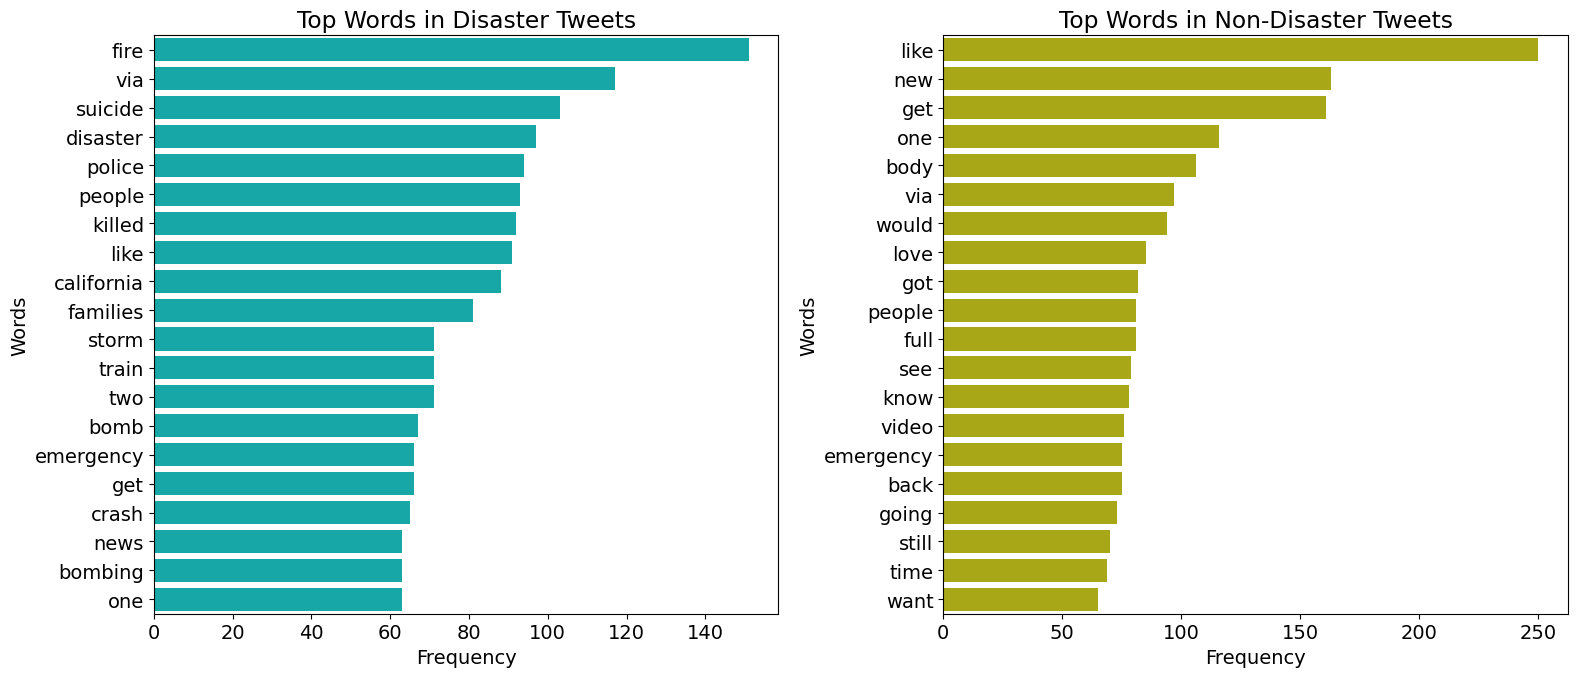

In [ ]:
# Assuming 'train' is your DataFrame and it has a column 'text_clean' and 'target'
plt.figure(figsize=(16, 7))

# Calculate word frequency for disaster tweets
plt.subplot(121)
all_words_disaster = ' '.join(train.loc[train.target == 1, 'text_clean']).lower().split()
stop_words = set(stopwords.words('english'))
filtered_words_disaster = [w for w in all_words_disaster if w not in stop_words and w.isalpha()]
word_freq_disaster = Counter(filtered_words_disaster)

# Create DataFrame and get top 20 words for disaster tweets
df_d = pd.DataFrame.from_dict(word_freq_disaster, orient='index', columns=['count'])
top20_d = df_d.sort_values('count', ascending=False).head(20)

# Plotting top words in disaster tweets
sns.barplot(x=top20_d['count'], y=top20_d.index, color='c')
plt.title('Top Words in Disaster Tweets')
plt.xlabel('Frequency')
plt.ylabel('Words')

# Calculate word frequency for non-disaster tweets
plt.subplot(122)
all_words_non_disaster = ' '.join(train.loc[train.target == 0, 'text_clean']).lower().split()
filtered_words_non_disaster = [w for w in all_words_non_disaster if w not in stop_words and w.isalpha()]
word_freq_non_disaster = Counter(filtered_words_non_disaster)

# Create DataFrame and get top 20 words for non-disaster tweets
df_nd = pd.DataFrame.from_dict(word_freq_non_disaster, orient='index', columns=['count'])
top20_nd = df_nd.sort_values('count', ascending=False).head(20)

# Plotting top words in non-disaster tweets
sns.barplot(x=top20_nd['count'], y=top20_nd.index, color='y')
plt.title('Top Words in Non-Disaster Tweets')
plt.xlabel('Frequency')
plt.ylabel('Words')

plt.tight_layout()
plt.show()

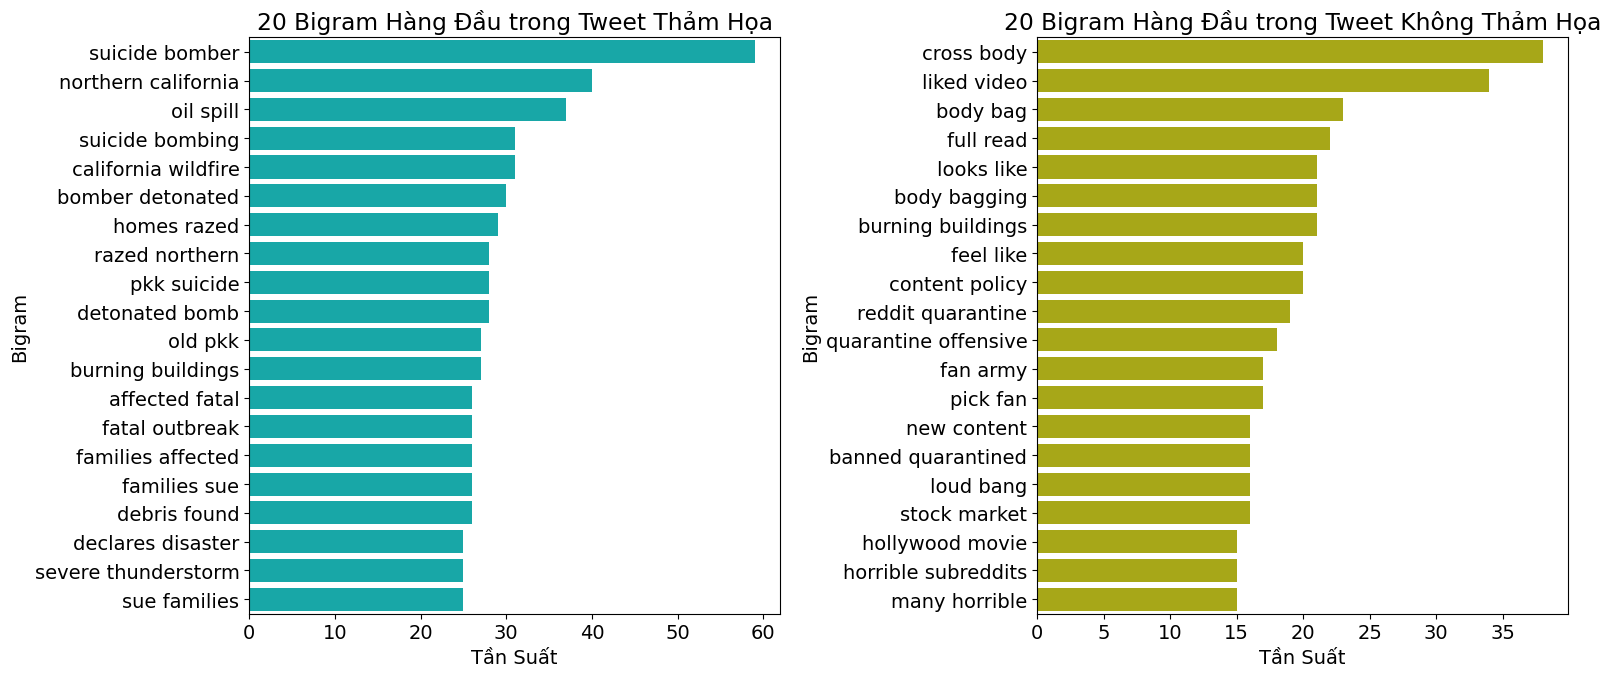

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import bigrams
from collections import Counter
from nltk.corpus import stopwords




plt.figure(figsize=(16, 7))

# Tính toán bigram cho tweet thảm họa
plt.subplot(121)
all_words_disaster = ' '.join(train.loc[train.target == 1, 'text_clean']).lower().split()
stop_words = set(stopwords.words('english'))
filtered_words_disaster = [w for w in all_words_disaster if w not in stop_words and w.isalpha()]

# Tạo bigram và đếm tần suất
bigrams_disaster = list(bigrams(filtered_words_disaster))
bigram_freq_disaster = Counter(bigrams_disaster)

# Tạo DataFrame và lấy 20 bigram hàng đầu cho tweet thảm họa
df_bd = pd.DataFrame.from_dict(bigram_freq_disaster, orient='index', columns=['count'])
top20_bd = df_bd.sort_values('count', ascending=False).head(20)

# Vẽ biểu đồ bigram hàng đầu trong tweet thảm họa
top20_bd.index = [' '.join(bigram) for bigram in top20_bd.index]  # Chuyển bigram thành chuỗi
sns.barplot(x=top20_bd['count'], y=top20_bd.index, color='c')
plt.title('20 Bigram Hàng Đầu trong Tweet Thảm Họa')
plt.xlabel('Tần Suất')
plt.ylabel('Bigram')

# Tính toán bigram cho tweet không thảm họa
plt.subplot(122)
all_words_non_disaster = ' '.join(train.loc[train.target == 0, 'text_clean']).lower().split()
filtered_words_non_disaster = [w for w in all_words_non_disaster if w not in stop_words and w.isalpha()]

# Tạo bigram và đếm tần suất
bigrams_non_disaster = list(bigrams(filtered_words_non_disaster))
bigram_freq_non_disaster = Counter(bigrams_non_disaster)

# Tạo DataFrame và lấy 20 bigram hàng đầu cho tweet không thảm họa
df_bnd = pd.DataFrame.from_dict(bigram_freq_non_disaster, orient='index', columns=['count'])
top20_bnd = df_bnd.sort_values('count', ascending=False).head(20)

# Vẽ biểu đồ bigram hàng đầu trong tweet không thảm họa
top20_bnd.index = [' '.join(bigram) for bigram in top20_bnd.index]  # Chuyển bigram thành chuỗi
sns.barplot(x=top20_bnd['count'], y=top20_bnd.index, color='y')
plt.title('20 Bigram Hàng Đầu trong Tweet Không Thảm Họa')
plt.xlabel('Tần Suất')
plt.ylabel('Bigram')

plt.tight_layout()
plt.show()

# Encoding and Vectorizers

As part of feature generation, we will:

- Apply target encoding to keyword and location (cleaned)
- Count Vectorize cleaned text, links, hashtags and mentions columns


In [69]:
import category_encoders as ce

# Target encoding
features = ['keyword', 'location']
encoder = ce.TargetEncoder(cols=features)
encoder.fit(train[features],train['target'])

train = train.join(encoder.transform(train[features]).add_suffix('_target'))
test = test.join(encoder.transform(test[features]).add_suffix('_target'))

In [70]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer cho liên kết
vec_links = CountVectorizer(min_df=5, analyzer='word', token_pattern=r'https?://\S+')  # Chỉ bao gồm các liên kết >=5 lần xuất hiện
link_vec = vec_links.fit_transform(train['links'])
link_vec_test = vec_links.transform(test['links'])
X_train_link = pd.DataFrame(link_vec.toarray(), columns=vec_links.get_feature_names_out())
X_test_link = pd.DataFrame(link_vec_test.toarray(), columns=vec_links.get_feature_names_out())

# CountVectorizer cho đề cập
vec_men = CountVectorizer(min_df=5)
men_vec = vec_men.fit_transform(train['mentions'])
men_vec_test = vec_men.transform(test['mentions'])
X_train_men = pd.DataFrame(men_vec.toarray(), columns=vec_men.get_feature_names_out())
X_test_men = pd.DataFrame(men_vec_test.toarray(), columns=vec_men.get_feature_names_out())

# CountVectorizer cho hashtag
vec_hash = CountVectorizer(min_df=5)
hash_vec = vec_hash.fit_transform(train['hashtags'])
hash_vec_test = vec_hash.transform(test['hashtags'])
X_train_hash = pd.DataFrame(hash_vec.toarray(), columns=vec_hash.get_feature_names_out())
X_test_hash = pd.DataFrame(hash_vec_test.toarray(), columns=vec_hash.get_feature_names_out())

# In kích thước của các DataFrame đã tạo
print(X_train_link.shape, X_train_men.shape, X_train_hash.shape)


(7613, 6) (7613, 18) (7613, 107)


C:\Users\qn570\AppData\Local\Temp\ipykernel_17468\3462187730.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




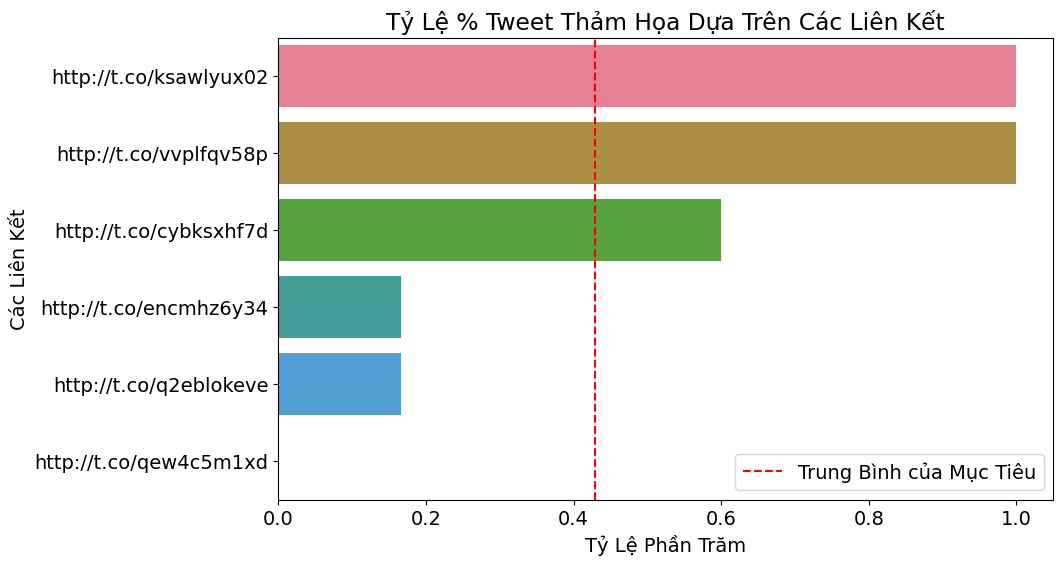

In [72]:
# Tính toán tỷ lệ phần trăm của tweet thảm họa dựa trên các liên kết
percentages = (X_train_link.transpose().dot(train['target']) / X_train_link.sum(axis=0)).sort_values(ascending=False)

# Tạo một biểu đồ với mỗi cột một màu sắc riêng
plt.figure(figsize=(10, 6))
colors = sns.color_palette("husl", len(percentages))  # Lấy màu sắc khác nhau cho mỗi cột

sns.barplot(x=percentages, y=percentages.index, palette=colors)  # Sử dụng palette màu
plt.axvline(np.mean(train.target), color='red', linestyle='--', label='Trung Bình của Mục Tiêu')  # Thêm đường trung bình
plt.title('Tỷ Lệ % Tweet Thảm Họa Dựa Trên Các Liên Kết')
plt.xlabel('Tỷ Lệ Phần Trăm')
plt.ylabel('Các Liên Kết')
plt.legend()
plt.show()

C:\Users\qn570\AppData\Local\Temp\ipykernel_17468\2220202976.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




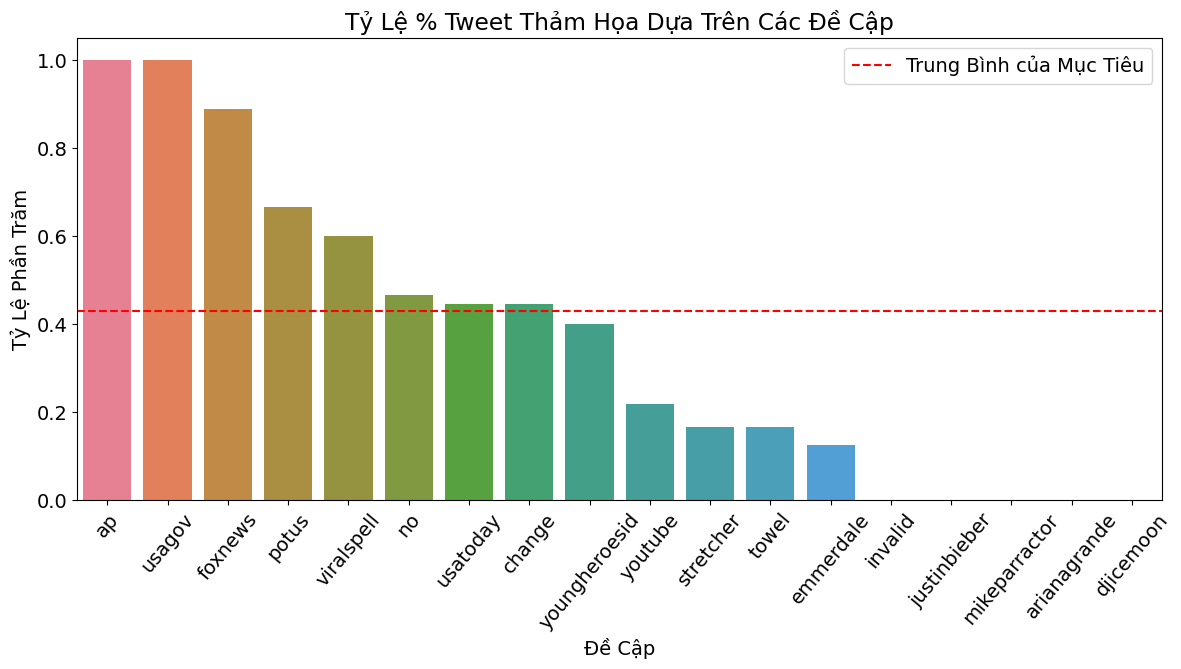

In [73]:
# Tính toán tỷ lệ phần trăm của tweet thảm họa dựa trên các đề cập
percentages_mentions = (X_train_men.transpose().dot(train['target']) / X_train_men.sum(axis=0)).sort_values(ascending=False)

# Tạo biểu đồ với mỗi cột một màu sắc riêng
plt.figure(figsize=(14, 6))
colors = sns.color_palette("husl", len(percentages_mentions))  # Lấy màu sắc khác nhau cho mỗi cột

sns.barplot(x=percentages_mentions.index, y=percentages_mentions, palette=colors)  # Sử dụng palette màu
plt.axhline(np.mean(train.target), color='red', linestyle='--', label='Trung Bình của Mục Tiêu')  # Thêm đường trung bình
plt.title('Tỷ Lệ % Tweet Thảm Họa Dựa Trên Các Đề Cập')
plt.xlabel('Đề Cập')
plt.ylabel('Tỷ Lệ Phần Trăm')
plt.xticks(rotation=50)  # Xoay nhãn trên trục x
plt.legend()
plt.show()

In [ ]:
hash_rank = (X_train_hash.transpose().dot(train['target']) / X_train_hash.sum(axis=0)).sort_values(ascending=False)
print('Hashtags with which 100% of Tweets are disasters: ')
print(list(hash_rank[hash_rank==1].index))
print('Total: ' + str(len(hash_rank[hash_rank==1])))
print('Hashtags with which 0% of Tweets are disasters: ')
print(list(hash_rank[hash_rank==0].index))
print('Total: ' + str(len(hash_rank[hash_rank==0])))

Hashtags with which 100% of Tweets are disasters: 
['abstorm', 'earthquake', 'hiroshima', 'india', 'japan', 'libya', 'africa', 'mumbai', 'myanmar', 'newyork', 'okwx', 'rohingya', 'science', 'sittwe', 'socialnews', 'wildfire', 'wildfires', 'worldnews', 'wx', 'hailstorm', 'mh370', 'yyc', 'disaster', 'breaking', 'bestnaijamade', 'antioch']
Total: 26
Hashtags with which 0% of Tweets are disasters: 
['dubstep', 'edm', 'animalrescue', 'fashion', 'technology', 'dance', 'trapmusic', 'ices', 'np', 'job', 'jobs', 'summerfate', 'kindle', 'soundcloud', 'military', 'bb17', 'beyhive', 'dnb']
Total: 18


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Tạo TfidfVectorizer
vec_text = TfidfVectorizer(min_df=10, ngram_range=(1, 2), stop_words='english')  # Chỉ bao gồm >=10 lần xuất hiện và có unigram và bigram

# Chuyển đổi dữ liệu huấn luyện và kiểm tra
text_vec = vec_text.fit_transform(train['text_clean'])
text_vec_test = vec_text.transform(test['text_clean'])

# Chuyển đổi ma trận thành DataFrame
X_train_text = pd.DataFrame(text_vec.toarray(), columns=vec_text.get_feature_names_out())
X_test_text = pd.DataFrame(text_vec_test.toarray(), columns=vec_text.get_feature_names_out())

# In kích thước của DataFrame
print(X_train_text.shape)


(7613, 1691)


In [ ]:
# Joining the dataframes together

train = train.join(X_train_link, rsuffix='_link')
train = train.join(X_train_men, rsuffix='_mention')
train = train.join(X_train_hash, rsuffix='_hashtag')
train = train.join(X_train_text, rsuffix='_text')
test = test.join(X_test_link, rsuffix='_link')
test = test.join(X_test_men, rsuffix='_mention')
test = test.join(X_test_hash, rsuffix='_hashtag')
test = test.join(X_test_text, rsuffix='_text')
print (train.shape, test.shape)

(7613, 1842) (3263, 1841)


## Model Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

features_to_drop = ['id', 'keyword','location','text','location','text_clean', 'hashtags', 'mentions','links']
scaler = MinMaxScaler()

X_train = train.drop(columns = features_to_drop + ['target'])
X_test = test.drop(columns = features_to_drop)
y_train = train.target

lr = LogisticRegression(solver='liblinear', random_state=777) # Other solvers have failure to converge problem

pipeline = Pipeline([('scale',scaler), ('lr', lr),])

pipeline.fit(X_train, y_train)
y_test = pipeline.predict(X_test)

submit = sub_sample.copy()
submit.target = y_test
submit.to_csv('submit_lr.csv',index=False)

In [ ]:
print ('Training accuracy: %.4f' % pipeline.score(X_train, y_train))

Training accuracy: 0.9050


In [ ]:
from sklearn.metrics import f1_score

print ('Training f-1 score: %.4f' % f1_score(y_train, pipeline.predict(X_train)))# F-1 score


Training f-1 score: 0.8858


In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_train, pipeline.predict(X_train)))

,0,1
0,4085,257
1,466,2805
